# Data Cleaning | NLP Classification

## The problem

Following a data-centric approach, the quality of the machine learning (ML) model is highly dependent on the quality of the data used to train it. Unfortunately, despite curators best efforts, the provided data can still include errors or miss-classifications. It is a well-known issue that data scientists spend more than half their time cleaning the data. One challenge for using a dataset is that there is no "go-to" method of finding errors in the dataset, such as faulty labels or samples that do not fit the business use case.

## The solution: Coresets

Coresets refer to a sampling methodology originating in computational geometry used to approximate optimization problems. They are based on selecting a subset of the original dataset that maintains the entire dataset's statistical properties (including the corner cases). Training a model on the Coreset should give the same result as training it on the full dataset.

When computing a Coreset, every instance in the dataset is assigned an importance value, which indicates how important it is to the final ML model. Samples that receive a high importance value in the Coreset computation require the attention of the data scientist as they usually indicate a labeling error or other data-related issues. Therefore, leveraging the Coresets, we can easily assign an importance score to each sample. Instances with high importance scores have a high probability of being mislabeled. Thus, we can sample instances of interest by looking at the top percentile of importance.

In the end, by speeding up the cleaning process of the dataset, the data scientists can focus on bringing real value and not on curating tasks.

# The goal of this notebook

We will use the Ag News NLP dataset to compute the importance values of all the samples within a class of interest using the coreset logistic regression service. With the help of the important values, we will quickly find samples that are hard to predict or might be mislabeled. Thus, accelerating the cleaning process of the dataset.

We preprocessed the text into embedding using a pretrained Bert model. By doing this, we can successfully run a logistic regression coresets service on top of the resulting embeddings.

# Import Dependencies

In [1]:
import json
import os
import time
from collections import defaultdict
from pathlib import Path
from typing import Tuple

import gdown
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.figure import Figure
from sklearn.exceptions import ConvergenceWarning

In [2]:
# Import the logistic regression Coreset service, which we will use to find important samples within the dataset.
from dataheroes import CoresetTreeServiceLG

In [3]:
# Ignore convergence warnings for logistic regression.
import warnings

warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

In [4]:
# Set a random seed for reproducability.
np.random.seed(42)

## Create a DataHeroes account
If you haven't done this already, please uncomment below lines to create a free DataHeroes account.
This step is required only once.

In [5]:
# from dataheroes.utils import activate_account
# activate_account('<your email address>')

# Load data

### How We Computed the Embeddings 👇


The features we will load are already precomputed within a different script. These were computed from the Ag News dataset with the following steps.
1. We initialized a pretrained Bert classifier. We dropped the last classification layer to output an embedding instead of the class distribution.
2. We passed all the text through the Bert model, which outputs a 768 embedding.

**NOTE:** We moved these steps to a different script because it takes a few hours to run. Also, you need a GPU and extra dependencies to run it properly. Thus we wanted to make this notebook as light as possible.

The raw dataset represents the actual/raw text used as input to the NLP Bert model.

The data you need for this notebook is placed [here](https://drive.google.com/drive/folders/1INdDvHDSofByGIqpd7oEwhgYZRsPBFtn).
We will download the contents of a folder called AG_News and place the data at data/ag_news.
The folder contains four files.
- raw_train.npy: Raw text data
- x_train.npy: Text embeddings of every sample
- y_train.npy: Labels (encoded) for every sample
- dataset_legend.json: Original label names.

The folder size exceeds 1GB, the download may take a few minutes.

In [6]:
# Folder identifier on Google Drive
AG_NEWS_PUBLIC_DATA_DIR = 'https://drive.google.com/drive/folders/1INdDvHDSofByGIqpd7oEwhgYZRsPBFtn'
DOWNLOAD_DATA = True

# Location of the preprocessed ag news dataset. Change to your preferred location if needed.
DATA_DIR = Path("data/ag_news")

In [7]:
# Download Data from the DataHeroes public repository
if DOWNLOAD_DATA:
    print("Downloading files...")
    gdown.download_folder(AG_NEWS_PUBLIC_DATA_DIR, output=str(DATA_DIR), use_cookies=False, quiet=False)

Retrieving folder list


Processing file 16fL6eK0UsqfgSXWRZfDvvVxc_1bod9oy dataset_legend.json
Processing file 19pnD2o1BPO8LGpu6PCuL9FqcqxDNc66Y raw_train.npy
Processing file 1PAym7GddBBRKOCrY1IGGNrYfhMvQMmsJ x_train.npy
Processing file 1PFeQPyEyZe6E0PVHcT069_HgQDr57A93 y_train.npy
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=16fL6eK0UsqfgSXWRZfDvvVxc_1bod9oy
To: /Users/alonftecha/work/dh/libProject/dh-library/examples/cleaning/examples/data/ag_news/dataset_legend.json
100%|██████████| 43.0/43.0 [00:00<00:00, 48.5kB/s]
Downloading...
From: https://drive.google.com/uc?id=19pnD2o1BPO8LGpu6PCuL9FqcqxDNc66Y
To: /Users/alonftecha/work/dh/libProject/dh-library/examples/cleaning/examples/data/ag_news/raw_train.npy
100%|██████████| 405M/405M [00:15<00:00, 26.9MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1PAym7GddBBRKOCrY1IGGNrYfhMvQMmsJ
To: /Users/alonftecha/work/dh/libProject/dh-library/examples/cleaning/examples/data/ag_news/x_train.npy
100%|██████████| 614M/614M [00:20<00:00, 29.6MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1PFeQPyEyZe6E0PVHcT069_HgQDr57A93
To: /Users/alonftecha/work/dh/libProject/dh-library/examples/cleaning/examples/data/ag_news/y_train.npy
100%|████████

In [8]:
# Load data to memory
raw_data = np.load(DATA_DIR/"raw_train.npy")
labels = json.load(open(DATA_DIR/"dataset_legend.json"))
X = np.load(DATA_DIR/"x_train.npy")
y = np.load(DATA_DIR/"y_train.npy")

def decode_label(label_idx):
    return labels[label_idx]

def encode_label(label):
    return labels.index(label)

print(f"Loaded X - shape = {X.shape}")
print(f"Loaded y - shape = {y.shape}")
print(f'y-label mapping = {dict(enumerate(labels))}')

Loaded X - shape = (100000, 768)
Loaded y - shape = (100000,)
y-label mapping = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}


## Visualise the original samples distribution

Text(0, 0.5, 'Counts')

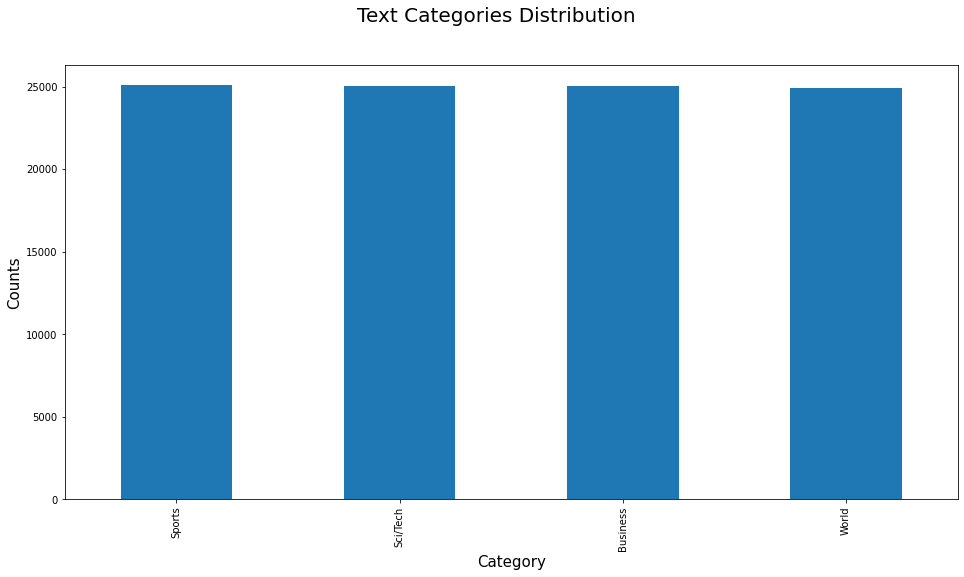

In [9]:
fig, ax = plt.subplots(figsize=(16, 8))
labels_distribution = pd.Series(y).value_counts()
labels_distribution.index = [decode_label(class_id) for class_id in labels_distribution.index]
labels_distribution.plot.bar()
fig.suptitle("Text Categories Distribution", fontsize=20)
ax.set_xlabel("Category", fontsize=15)
ax.set_ylabel("Counts", fontsize=15)

## Pick the class of interest

In [10]:
of_interest_class_name = 'World'
of_interest_class_id = encode_label(of_interest_class_name)

print(f"Our class of interest is '{of_interest_class_name}'.")
print(f"It has a total of {labels_distribution[of_interest_class_name]} samples/text entries.")

Our class of interest is 'World'.
It has a total of 24900 samples/text entries.


# Compute the Importance Using Coresets

With the help of the `CoresetServiceLG` class, we will find the samples of interest within the `of_interest_class_id` class. This service will compute the coreset relative to the given data and logistic regression. Using the coreset, it can assign importance values with the help of which we will find our samples of interest.

In [11]:
# Build coreset
start_service_time = time.time()

service = CoresetTreeServiceLG(optimized_for='cleaning')
service.build(X, y)
end_service_time = time.time()

print(f"Coreset computed in {end_service_time - start_service_time:.2f} seconds")

Coreset computed in 10.99 seconds


## Visualise samples importance

In [12]:
# Get samples importance for the class of interest.
important_samples = service.get_cleaning_samples(class_size={of_interest_class_id: "all"})
# if you're interested in getting data for all classes use the size parameter as shown below.
# important_samples = service.get_cleaning_samples(size=len(X))
important_sample_indices, important_sample_values = important_samples["idx"], important_samples["importance"]

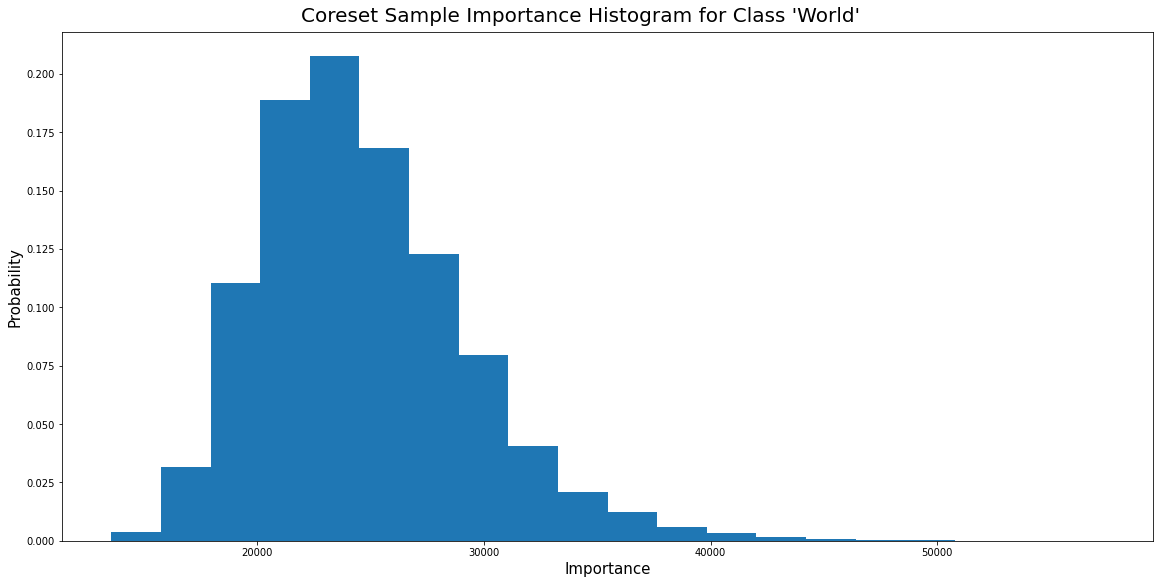

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8), constrained_layout=True)
fig.suptitle(f"Coreset Sample Importance Histogram for Class '{of_interest_class_name}'", fontsize=20)
ax.set_xlabel("Importance", fontsize=15)
ax.set_ylabel("Probability", fontsize=15)

plt.hist(
    important_sample_values,
    bins=20,
    density=False,
    weights=np.ones(len(important_sample_values)) / len(important_sample_values)
);

# Visualise Samples Sorted By Importance

We will visualize the data samples from the top and bottom ends of the importance spectrum based on what we computed using the coresets service.

One important thing to highlight is that the indices and values returned by the coreset service are already sorted in descending order.

#### Visualisation Helper Methods


In [14]:
class bcolors:
    """Class that aggregates typing constants."""

    HEADER = '\033[95m'
    BOLD = '\033[1m'
    ENDC = '\033[0m'


def visualize(raw_train: np.ndarray, y_train: np.ndarray, importance_values: np.ndarray, sample_indices: np.array, title: str):
    """Generator used to visualize the samples and annotations within the Ag News dataset."""

    print(f"{bcolors.HEADER}{'*' * 40} {title} {'*' * 40}{bcolors.ENDC}")

    num_sections = len(raw_train) // 5 + 1
    chunks_raw_train = np.array_split(raw_train, num_sections)
    chunks_y_train = np.array_split(y_train, num_sections)
    chunks_importance_values = np.array_split(importance_values, num_sections)
    chunks_sample_indices = np.array_split(sample_indices, num_sections)
    for chunk_raw_train, chunk_y_train, chunk_importance_values, chunk_sample_indices in zip(chunks_raw_train, chunks_y_train,
                                                                                             chunks_importance_values,
                                                                                             chunks_sample_indices):
        for raw_train, label_id, importance_value, sample_index in zip(chunk_raw_train, chunk_y_train, chunk_importance_values, chunk_sample_indices):
            print(f"{bcolors.BOLD}Text{bcolors.ENDC}: {raw_train}")
            print(f"{bcolors.BOLD}Label Name{bcolors.ENDC}: {decode_label(label_id)}")
            print(f"{bcolors.BOLD}Importance Value{bcolors.ENDC}: {importance_value:.2f}")
            print(f"{bcolors.BOLD}Sample Index{bcolors.ENDC}: {sample_index}")
            print(f"{bcolors.HEADER}{'-' * 100}{bcolors.ENDC}")
        yield


def get_top(indices: np.ndarray, important_values: np.ndarray, n_samples: int):
    """Utility function that extracts top-importance samples based on the output from the coresets service."""

    indices = indices[:n_samples]
    important_values = important_values[:n_samples]
    raw_train = raw_data[indices]
    y_train = y[indices]
    return raw_train, y_train, important_values, indices


def get_bottom(indices: np.ndarray, important_values: np.ndarray, n_samples: int):
    """Utility function that extracts bottom-importance samples based on the output from the coresets service."""

    indices = indices[-n_samples:]
    important_values = important_values[-n_samples:]
    raw_train = raw_data[indices]
    y_train = y[indices]
    return raw_train, y_train, important_values, indices

#### Visualise Top Importance

Within the top-importance samples, we will find hard to predict samples or mislabeled samples.

Notice how the top importance samples contain examples that are either mislabeled or samples that should be dropped. In contrast, the
bottom importance samples primarily contain examples that are correctly classified. Based on this observation, we will proceed with
cleaning the data focusing on the top importance samples only.

In [15]:
top_important_raw_train, top_important_y_train, top_importance_values, top_important_sample_indices = get_top(important_sample_indices, important_sample_values, 150)
top_importance_visualizer = visualize(
    raw_train=top_important_raw_train,
    y_train=top_important_y_train,
    importance_values=top_importance_values,
    sample_indices=top_important_sample_indices,
    title="Top Importance"
)

In [16]:
# Print the first 5 most important samples. Repeat below to print more.
next(top_importance_visualizer)

**************************************** Top Importance ****************************************
Text: Massu Defeats Kucera at CA Trophy Olympic champion Nicolas Massu defeated Karol Kucera 6-4, 6-7 (5), 6-4 at the CA Trophy tournament on Tuesday.
Label Name: World
Importance Value: 57342.68
Sample Index: 16061
----------------------------------------------------------------------------------------------------
Text: Tennis: Sharapova wins finale Maria Sharapova beats Serena Williams 4-6 6-2 6-4 in the Tour Championships final.
Label Name: World
Importance Value: 55705.27
Sample Index: 89787
----------------------------------------------------------------------------------------------------
Text: Boxing: Williams to face Klitschko Danny Williams will take on WBC world heavyweight champion Vitali Klitschko in December.
Label Name: World
Importance Value: 50820.71
Sample Index: 88811
----------------------------------------------------------------------------------------------------
Text:

The top importance samples contain mostly examples that are mislabeled and belong to the Sports class.

#### Visualise Bottom Importance

In [17]:
bottom_important_raw_train, bottom_important_y_train, bottom_importance_values, bottom_important_sample_indices = get_bottom(important_sample_indices,  important_sample_values, 150)
bottom_importance_visualizer = visualize(
    raw_train=bottom_important_raw_train,
    y_train=bottom_important_y_train,
    importance_values=bottom_importance_values,
    sample_indices=bottom_important_sample_indices,
    title="Bottom Importance"
)

In [18]:
# Print the 5 least important samples. Repeat below to print more.
next(bottom_importance_visualizer)

**************************************** Bottom Importance ****************************************
Text: Israelis Kill Five Palestinians in Gaza Strip  GAZA (Reuters) - Israeli troops killed five armed  Palestinians in the Gaza Strip on Saturday as it pressed on  with a massive offensive aimed at stopping militants firing  rockets into Israel.
Label Name: World
Importance Value: 16066.30
Sample Index: 11519
----------------------------------------------------------------------------------------------------
Text: Sudan bows to pressure, allows AU to monitor police in Darfur &lt;b&gt;...&lt;/b&gt; KHARTOUM (AFP) - Sudan bowed to mounting pressure over the crisis in Darfur and agreed to allow African Union forces to monitor the activities of its police in camps for displaced persons in the region.
Label Name: World
Importance Value: 16064.61
Sample Index: 36024
----------------------------------------------------------------------------------------------------
Text: Ten killed in US air 

In contrast to the top importance samples we previously investigated, the bottom importance samples show only correctly classified samples.

## Fix some samples
Based on the above top important samples, we can see that all should be relabeled as ‘Sports’.
We will update the label to some of these samples and in addition, we will remove some samples from the dataset, just to simulate this functionality.

In [19]:
# Take the top 3 important samples and update their label to Sports.
indices_to_fix = [89787, 16061, 61077]  # Top 3
new_labels = ['Sports', 'Sports', 'Sports']
# encode new_labels
new_labels_ids = [encode_label(c) for c in new_labels]
service.update_targets(indices_to_fix, new_labels_ids)

# Take 2 samples and remove them from the tree.
indices_to_remove = [42447, 90762]
service.remove_samples(indices_to_remove)